fine tuning a model with a dataset in romanian, and test it.
the model will be speech brain and chose a dataset facebook/voxpopuli

https://huggingface.co/learn/audio-course/chapter6/fine-tuning

In [3]:
%pip install transformers datasets soundfile speechbrain accelerate speechbrain

Note: you may need to restart the kernel to use updated packages.


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [98]:
from datasets import load_from_disk, Audio

dataset2 = load_from_disk("./rodigits/rodigits/rodigits_dataset")
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 11120
    })
    test: Dataset({
        features: ['speaker_id', 'audio', 'transcription'],
        num_rows: 2780
    })
    eval: Dataset({
        features: ['speaker_id', 'audio', 'transcription'],
        num_rows: 1489
    })
})

In [82]:
dataset['train'][0]

{'speaker_id': '006',
 'audio': {'path': '006_10_0001.wav',
  'array': array([0.07015991, 0.07009888, 0.07003784, ..., 0.06466675, 0.06561279,
         0.06619263]),
  'sampling_rate': 16000},
 'transcription': 'șapte șapte șapte nouă șase cinci șase nouă zero trei patru unu'}

In [80]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [51]:
dataset

DatasetDict({
    train: Dataset({
        features: ['speaker_id', 'audio', 'transcription'],
        num_rows: 11120
    })
    test: Dataset({
        features: ['speaker_id', 'audio', 'transcription'],
        num_rows: 2780
    })
    eval: Dataset({
        features: ['speaker_id', 'audio', 'transcription'],
        num_rows: 1489
    })
})

In [8]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

c:\Users\na\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
tokenizer = processor.tokenizer

In [52]:
replacements = [
    (" ", " "),
    ("1", "un"),
    ("ă", "a"),
    ("â", "a"),
    ("î", "i"),
    ("ș", "s"),
    ("ț", "t"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["transcription"] = inputs["transcription"].replace(src, dst)
    return inputs


dataset['train'] = dataset['train'].map(cleanup_text)
dataset['test'] = dataset['test'].map(cleanup_text)
dataset['eval'] = dataset['eval'].map(cleanup_text)

In [13]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset['train']["speaker_id"]:
    speaker_counts[speaker_id] += 1

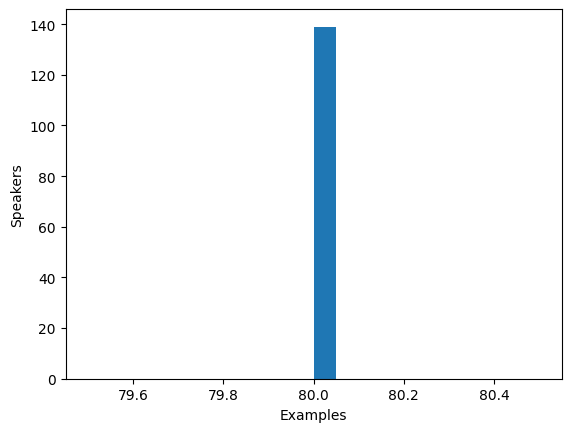

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

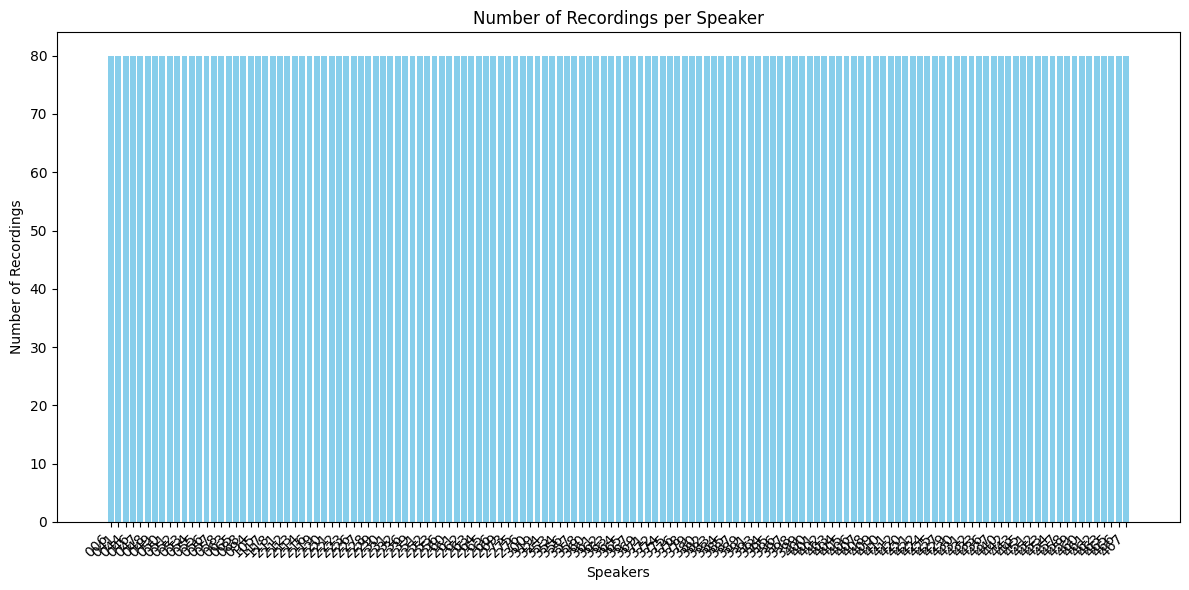

In [15]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.bar(speaker_counts.keys(), speaker_counts.values(), color='skyblue')

# Add labels and title
plt.ylabel("Number of Recordings")
plt.xlabel("Speakers")
plt.title("Number of Recordings per Speaker")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['speaker_id', 'audio', 'transcription'],
        num_rows: 11120
    })
    test: Dataset({
        features: ['speaker_id', 'audio', 'transcription'],
        num_rows: 2780
    })
    eval: Dataset({
        features: ['speaker_id', 'audio', 'transcription'],
        num_rows: 1489
    })
})

In [17]:
%pip install speechbrain

Note: you may need to restart the kernel to use updated packages.


In [18]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier
spk_model_name = "speechbrain/spkrec-xvect-voxceleb"
device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
c:\Users\na\AppData\Local\Programs\Python\Python310\lib\inspect.py:869: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
C:\Users\na\AppData\Local\Temp\ipykernel_22908\797619253.py:3: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier
INFO:speechbrain.utils.fetching:Fetch hyperparam

In [19]:
device

'cuda'

In [20]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["transcription"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [21]:
processed_example = prepare_dataset(dataset['train'][0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [22]:
processed_example["speaker_embeddings"].shape

(512,)

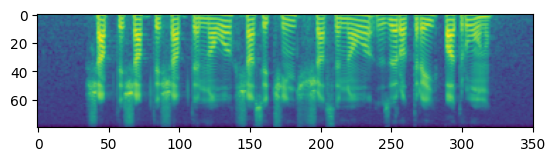

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [54]:
dataset.column_names

{'train': ['input_ids', 'labels', 'speaker_embeddings'],
 'test': ['speaker_id', 'audio', 'transcription'],
 'eval': ['speaker_id', 'audio', 'transcription']}

In [92]:
dataset['train'] = dataset['train'].map(prepare_dataset, remove_columns=dataset['train'].column_names)
# dataset['test'] = dataset['test'].map(prepare_dataset, remove_columns=dataset['test'].column_names)
# dataset['eval'] = dataset['eval'].map(prepare_dataset, remove_columns=dataset['eval'].column_names)

Map:   0%|          | 0/11120 [00:00<?, ? examples/s]

In [26]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [27]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [28]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

c:\Users\na\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [29]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [30]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="sst_rodigits",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=5000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [31]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

max_steps is given, it will override any value given in num_train_epochs


In [32]:
trainer.train()

  0%|          | 0/5000 [00:00<?, ?it/s]

c:\Users\na\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


{'loss': 0.8139, 'grad_norm': 9.839905738830566, 'learning_rate': 4.800000000000001e-07, 'epoch': 0.07}
{'loss': 0.7173, 'grad_norm': 2.764512300491333, 'learning_rate': 9.800000000000001e-07, 'epoch': 0.14}
{'loss': 0.7016, 'grad_norm': 4.366049766540527, 'learning_rate': 1.48e-06, 'epoch': 0.22}
{'loss': 0.6626, 'grad_norm': 5.024562835693359, 'learning_rate': 1.98e-06, 'epoch': 0.29}
{'loss': 0.6238, 'grad_norm': 2.6631662845611572, 'learning_rate': 2.4800000000000004e-06, 'epoch': 0.36}
{'loss': 0.6137, 'grad_norm': 2.0791022777557373, 'learning_rate': 2.9800000000000003e-06, 'epoch': 0.43}
{'loss': 0.5841, 'grad_norm': 2.5965158939361572, 'learning_rate': 3.48e-06, 'epoch': 0.5}
{'loss': 0.5695, 'grad_norm': 2.189399003982544, 'learning_rate': 3.980000000000001e-06, 'epoch': 0.58}
{'loss': 0.5628, 'grad_norm': 2.103375196456909, 'learning_rate': 4.48e-06, 'epoch': 0.65}
{'loss': 0.5507, 'grad_norm': 1.8947961330413818, 'learning_rate': 4.980000000000001e-06, 'epoch': 0.72}
{'loss'

  0%|          | 0/1390 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


{'eval_loss': 0.38120731711387634, 'eval_runtime': 65.5587, 'eval_samples_per_second': 42.405, 'eval_steps_per_second': 21.202, 'epoch': 2.88}


c:\Users\na\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


{'loss': 0.4282, 'grad_norm': 1.615124225616455, 'learning_rate': 8.835555555555557e-06, 'epoch': 2.95}
{'loss': 0.4252, 'grad_norm': 1.4403810501098633, 'learning_rate': 8.78e-06, 'epoch': 3.02}
{'loss': 0.431, 'grad_norm': 1.901129126548767, 'learning_rate': 8.724444444444445e-06, 'epoch': 3.09}
{'loss': 0.4218, 'grad_norm': 1.144036889076233, 'learning_rate': 8.66888888888889e-06, 'epoch': 3.17}
{'loss': 0.4224, 'grad_norm': 1.5459067821502686, 'learning_rate': 8.613333333333333e-06, 'epoch': 3.24}
{'loss': 0.4222, 'grad_norm': 1.556275486946106, 'learning_rate': 8.557777777777778e-06, 'epoch': 3.31}
{'loss': 0.4211, 'grad_norm': 2.037501811981201, 'learning_rate': 8.502222222222223e-06, 'epoch': 3.38}
{'loss': 0.4217, 'grad_norm': 1.9422763586044312, 'learning_rate': 8.446666666666668e-06, 'epoch': 3.45}
{'loss': 0.417, 'grad_norm': 1.2143293619155884, 'learning_rate': 8.391111111111112e-06, 'epoch': 3.53}
{'loss': 0.4177, 'grad_norm': 1.4371386766433716, 'learning_rate': 8.3355555

  0%|          | 0/1390 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


{'eval_loss': 0.3674603998661041, 'eval_runtime': 64.8313, 'eval_samples_per_second': 42.881, 'eval_steps_per_second': 21.44, 'epoch': 5.76}


c:\Users\na\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


{'loss': 0.3988, 'grad_norm': 2.0328800678253174, 'learning_rate': 6.613333333333334e-06, 'epoch': 5.83}
{'loss': 0.4125, 'grad_norm': 2.5434176921844482, 'learning_rate': 6.557777777777778e-06, 'epoch': 5.9}
{'loss': 0.4073, 'grad_norm': 1.5037221908569336, 'learning_rate': 6.502222222222223e-06, 'epoch': 5.97}
{'loss': 0.4099, 'grad_norm': 1.2968990802764893, 'learning_rate': 6.446666666666668e-06, 'epoch': 6.04}
{'loss': 0.4048, 'grad_norm': 1.8737798929214478, 'learning_rate': 6.391111111111111e-06, 'epoch': 6.12}
{'loss': 0.4074, 'grad_norm': 1.5929927825927734, 'learning_rate': 6.335555555555556e-06, 'epoch': 6.19}
{'loss': 0.4046, 'grad_norm': 1.6922798156738281, 'learning_rate': 6.280000000000001e-06, 'epoch': 6.26}
{'loss': 0.3999, 'grad_norm': 1.337772250175476, 'learning_rate': 6.224444444444445e-06, 'epoch': 6.33}
{'loss': 0.4011, 'grad_norm': 1.3117225170135498, 'learning_rate': 6.16888888888889e-06, 'epoch': 6.4}
{'loss': 0.4025, 'grad_norm': 1.6185002326965332, 'learning

  0%|          | 0/1390 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


{'eval_loss': 0.3623502850532532, 'eval_runtime': 65.3498, 'eval_samples_per_second': 42.54, 'eval_steps_per_second': 21.27, 'epoch': 8.63}


c:\Users\na\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


{'loss': 0.3998, 'grad_norm': 1.4668959379196167, 'learning_rate': 4.393333333333334e-06, 'epoch': 8.71}
{'loss': 0.3966, 'grad_norm': 1.9377368688583374, 'learning_rate': 4.337777777777778e-06, 'epoch': 8.78}
{'loss': 0.3974, 'grad_norm': 1.624381184577942, 'learning_rate': 4.282222222222222e-06, 'epoch': 8.85}
{'loss': 0.397, 'grad_norm': 1.517173171043396, 'learning_rate': 4.226666666666667e-06, 'epoch': 8.92}
{'loss': 0.398, 'grad_norm': 1.445854902267456, 'learning_rate': 4.171111111111111e-06, 'epoch': 8.99}
{'loss': 0.3939, 'grad_norm': 1.4338093996047974, 'learning_rate': 4.115555555555556e-06, 'epoch': 9.06}
{'loss': 0.3993, 'grad_norm': 1.3140926361083984, 'learning_rate': 4.060000000000001e-06, 'epoch': 9.14}
{'loss': 0.3991, 'grad_norm': 1.594638705253601, 'learning_rate': 4.004444444444445e-06, 'epoch': 9.21}
{'loss': 0.3964, 'grad_norm': 1.5311514139175415, 'learning_rate': 3.948888888888889e-06, 'epoch': 9.28}
{'loss': 0.3911, 'grad_norm': 1.9811131954193115, 'learning_r

  0%|          | 0/1390 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


{'eval_loss': 0.3587823808193207, 'eval_runtime': 66.4565, 'eval_samples_per_second': 41.832, 'eval_steps_per_second': 20.916, 'epoch': 11.51}


c:\Users\na\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


{'loss': 0.3894, 'grad_norm': 1.3847326040267944, 'learning_rate': 2.1711111111111113e-06, 'epoch': 11.58}
{'loss': 0.3934, 'grad_norm': 1.5397535562515259, 'learning_rate': 2.1155555555555557e-06, 'epoch': 11.65}
{'loss': 0.3947, 'grad_norm': 1.2624269723892212, 'learning_rate': 2.06e-06, 'epoch': 11.73}
{'loss': 0.3918, 'grad_norm': 1.51913583278656, 'learning_rate': 2.0044444444444446e-06, 'epoch': 11.8}
{'loss': 0.3885, 'grad_norm': 1.2247381210327148, 'learning_rate': 1.948888888888889e-06, 'epoch': 11.87}
{'loss': 0.3964, 'grad_norm': 2.0583271980285645, 'learning_rate': 1.8933333333333333e-06, 'epoch': 11.94}
{'loss': 0.3889, 'grad_norm': 1.0831890106201172, 'learning_rate': 1.837777777777778e-06, 'epoch': 12.01}
{'loss': 0.395, 'grad_norm': 1.3413347005844116, 'learning_rate': 1.7822222222222225e-06, 'epoch': 12.09}
{'loss': 0.3935, 'grad_norm': 2.1992788314819336, 'learning_rate': 1.7266666666666667e-06, 'epoch': 12.16}
{'loss': 0.3952, 'grad_norm': 1.5239434242248535, 'learni

  0%|          | 0/1390 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


{'eval_loss': 0.358123779296875, 'eval_runtime': 63.9969, 'eval_samples_per_second': 43.44, 'eval_steps_per_second': 21.72, 'epoch': 14.39}
{'train_runtime': 4974.3818, 'train_samples_per_second': 32.165, 'train_steps_per_second': 1.005, 'train_loss': 0.4220878261566162, 'epoch': 14.39}


TrainOutput(global_step=5000, training_loss=0.4220878261566162, metrics={'train_runtime': 4974.3818, 'train_samples_per_second': 32.165, 'train_steps_per_second': 1.005, 'total_flos': 8909827453695168.0, 'train_loss': 0.4220878261566162, 'epoch': 14.388489208633093})

In [33]:
trainer.push_to_hub()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


CommitInfo(commit_url='https://huggingface.co/AdaCodruta/sst_rodigits/commit/9f68568a9a5067355a4100c1f535abccf0a84c72', commit_message='End of training', commit_description='', oid='9f68568a9a5067355a4100c1f535abccf0a84c72', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AdaCodruta/sst_rodigits', endpoint='https://huggingface.co', repo_type='model', repo_id='AdaCodruta/sst_rodigits'), pr_revision=None, pr_num=None)

In [34]:
from transformers import SpeechT5ForTextToSpeech
model = SpeechT5ForTextToSpeech.from_pretrained(
    "AdaCodruta/sst_rodigits"
)

c:\Users\na\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/194 [00:00<?, ?B/s]

In [35]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 11120
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 2780
    })
    eval: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 1489
    })
})

In [36]:
example = dataset["test"][15]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [37]:
text = "Imi pare bine sa va cunosc dragilor"

In [38]:
inputs = processor(text=text, return_tensors="pt")

In [39]:
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [91]:
dataset['test']

Dataset({
    features: ['speaker_id', 'audio', 'transcription'],
    num_rows: 2780
})

In [107]:
dataset2['train']

Dataset({
    features: ['speaker_id', 'audio', 'transcription'],
    num_rows: 11120
})

In [141]:
from IPython.display import Audio

example = dataset['train'][25]
# processed_example = prepare_dataset(example)
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
# text =dataset2['train'][25]['transcription']
# text ="unu doi trei unu doi trei patru cinci sase sapte opt noua"
text="unu trei opt sapte opt sapte sapte unu sase opt opt sapte "
print(text)
inputs = processor(text=text, return_tensors="pt")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)
Audio(speech.numpy(), rate=16000)

unu trei opt sapte opt sapte sapte unu sase opt opt sapte 


unu trei opt sapte opt sapte sapte unu sase opt opt sapte 


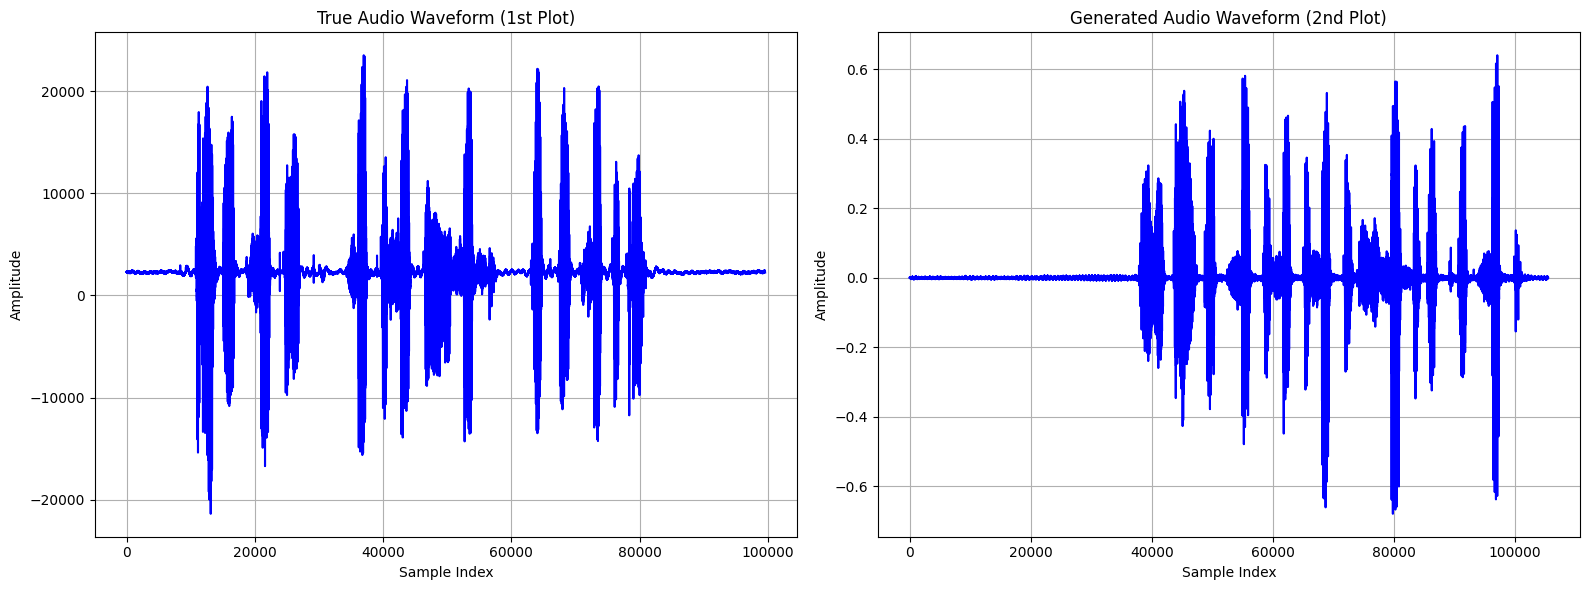

In [142]:
from scipy.signal import spectrogram
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read

sr_true_data, true_data = read(str("./rodigits/rodigits/006/"+dataset2['train'][25]['audio']['path']))



audio_data = speech.numpy()
print(text)
plt.figure(figsize=(16, 6))  # Adjust figure size

# Plot the first waveform
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(true_data, color='blue')
plt.title("True Audio Waveform (1st Plot)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

# Plot the second waveform
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(audio_data, color='blue')
plt.title("Generated Audio Waveform (2nd Plot)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()  # Ensure proper spacing between plots
plt.show()

In [143]:
from IPython.display import Audio
Audio(true_data, rate=16000)